# Model Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='1.' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, config as jconfig, jit, vmap, grad, debug, tree
# jconfig.update("jax_enable_x64", True)

from functools import partial
from getdist import plots
from numpyro import infer

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save
from montecosmo.script import from_id, get_mcmc, get_init_mcmc

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
@jit
def truc(x):
    assert jnp.result_type(x) is jnp.dtype(bool)
    return x

In [3]:
truc(True)

2025-02-02 19:02:15.424100: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Array(True, dtype=bool)

## Config and fiduc

In [4]:
################## TO SET #######################
# task_id = int(os.environ['SLURM_ARRAY_TASK_ID'])
task_id = 2030
print("SLURM_ARRAY_TASK_ID:", task_id)
model, mcmc_config, save_dir, save_path = from_id(task_id)
os.makedirs(save_dir, exist_ok=True)
print("save path:", save_path)

# import sys
# tempstdout, tempstderr = sys.stdout, sys.stderr
# sys.stdout = sys.stderr = open(save_path+'.out', 'a')
# job_id = int(os.environ['SLURM_ARRAY_JOB_ID'])
# print("SLURM_ARRAY_JOB_ID:", job_id)
# print("SLURM_ARRAY_TASK_ID:", task_id)
# print("jax_enable_x64:", jconfig.read("jax_enable_x64"))

SLURM_ARRAY_TASK_ID: 2030
save path: /feynman/home/dphp/hs276503/scratch/pickles/m32_b160.0_al0.5_ao0.5_lo0_pc3_obfield/sNUTS_nc4_ns2_mt10_ta0.65


In [5]:
print(model)
print(mcmc_config)
# model.render()

if not os.path.exists(save_dir+"truth.p"):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1.,
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, hide_samp=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    model.save(save_dir)    
    pdump(truth, save_dir+"truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir+"truth.p")

model.condition({'obs': truth['obs']})
model.delta_obs = truth['obs'] - 1
model.block()
# model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
# model.render()

# CONFIG
{'a_lpt': 0.5,
 'a_obs': 0.5,
 'box_shape': array([160., 160., 160.]),
 'gxy_density': 0.001,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'low': 0.05,
                         'scale': 0.2},
             'b1': {'group': 'bias',
                    'label': '{b}_1',
                    'loc': 1.0,
                    'scale': 0.5},
             'b2': {'group': 'bias',
                    'label': '{b}_2',
                    'loc': 0.0,
                    'scale': 2.0},
             'bn2': {'group': 'bias',
                     'label': '{b}_{\\nabla^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'bs2': {'group': 'bias',
                     'label': '{b}_{s^2}',
                     'loc': 0.0,
                     'scale': 2.0},
             'init_mesh': {'group': 'init',
               

## Run

### NUTS, HMC

In [5]:
continue_run = False
if continue_run:
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
else:
    model.reset()
    model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    model.block()

    # mcmc = get_init_mcmc(model.model, mcmc_config['n_chains'])    
    print("# Warmupping...")
    # init_params_ = jit(vmap(model.init_model))(jr.split(jr.key(45), mcmc.num_chains))
    # init_params_ = model.predict(45, samples=mcmc.num_chains, hide_samp=False)
    
    # if not os.path.exists(save_path + "_init_last_state.p"):
    #     init_mesh_ = {k: init_params_[k] for k in ['init_mesh_']} # NOTE: !!!!!!!
    #     mcmc = sample_and_save(mcmc, save_path+'_init', 0, 0, extra_fields=['num_steps'], init_params=init_mesh_)
    #     ils = mcmc.last_state.z
    # else:
    #     ils = pload(save_path + "_init_last_state.p").z
    
    # ils = {k: jnp.broadcast_to(v, (mcmc_config['n_chains'], *jnp.shape(v))) for k, v in truth.items()}
    # ils = {k+'_': ils[k+'_'] for k in ['Omega_m','sigma8','b1','b2','bs2','bn2','init_mesh']}


    # ################
    # from montecosmo.plot import plot_pow, plot_powtranscoh, plot_coh
    # mesh0 = jnp.fft.irfftn(truth['init_mesh'])
    # kptcs__ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_)
    # kptcs_ = vmap(lambda x: model.powtranscoh(mesh0, model.reparam(x, fourier=False)['init_mesh']))(init_params_ | ils)
    # kpk0 = model.spectrum(mesh0)
    # kptc_obs = model.powtranscoh(mesh0, truth['obs'] - 1)
    # kpkobs = model.spectrum(truth['obs']-1)
    
    # print(ils.keys(), init_params_.keys())

    # mse__ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # mse_ = jnp.mean((vmap(lambda x: model.reparam(x, fourier=False))(init_params_ | ils)['init_mesh']  - mesh0)**2, axis=(1,2,3))
    # print("MSEs:", mse_, mse_)

    # prob = 0.95
    # plt.figure(figsize=(12, 4))
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs__), 1), label='init')
    # plot_powtranscoh(*kptcs__, fill=prob)
    # plot_powtranscoh(*jnp.median(jnp.stack(kptcs_), 1), label='warm')
    # plot_powtranscoh(*kptcs_, fill=prob)
    # plt.subplot(131)
    # plot_pow(*kpk0, 'k', label='true')
    # plot_pow(*kpkobs, ':', c='grey', label='obs')
    # plt.legend()
    # plt.subplot(133)
    # plot_coh(kptc_obs[0], kptc_obs[-1], ':', c='grey', label='obs')
    # plt.tight_layout()
    # # plt.savefig(save_dir+f'initpk_{task_id}.png')
    # plt.savefig(f'init_glin_{task_id}.png')

    # last_state = pload(save_path + "_init_last_state.p")
    # print("mean_acc_prob:", last_state.mean_accept_prob, 
    #     "\nss:", last_state.adapt_state.step_size, 
    #     "\nmm_sqrt:", last_state.adapt_state.mass_matrix_sqrt)
    # ################    
    
    # init_params_ |= ils
    # init_params_ |= mcmc.last_state.z
    # print(init_params_.keys())
    model.reset()
    model.condition({'obs': truth['obs']})
    # init_params_ = {k:v for k,v in init_params_.items() if k in ['Omega_m_', 'sigma8_']} | ils
    # model.condition({'obs': truth['obs'], 'b1': truth['b1'], 'b2': truth['b2'], 'bs2': truth['bs2'], 'bn2': truth['bn2']}, frombase=True)
    model.block()

# Warmupping...


In [ ]:
if mcmc_config['sampler'] != 'NUTSwG':
    # model.reset()
    # model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    # model.block()
    # print(model.reparam(model.prior_loc))
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)
    if True or continue_run:
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 1
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=43, extra_fields=['num_steps'])

    else:
        # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
        mcmc_runned = sample_and_save(mcmc, save_path, 0, 0, extra_fields=['num_steps'], init_params=init_params_)

else:
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, mcmc_config['n_samples'], progress_bar=False)))
    start = 11
    end = start + mcmc_config['n_runs'] - 1
    key = jr.key(42)
    for i_run in range(start, end+1):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, mcmc_config['n_chains']), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")


run 1/10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


True <class 'bool'>
jnp.result_type(keep_step)=dtype('bool')
stepsize_controller=ConstantStepSize()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> False Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> diffrax._solution.RESULTS<>
Final True
True <class 'bool'>
jnp.result_type(keep_step)=dtype('bool')
stepsize_controller=ConstantStepSize()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> False Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> diffrax._solution.RESULTS<>
Final True
True
(array(0.13161081, dtype=float32), array(0.26322162, dtype=float32), array(False), array(0.13161081, dtype=float32), diffrax._solution.RESULTS<>)
True
(array(0.26322162, dtype=float32), array(0.39483243, dtype=float32), array(False), array(0.13161081, dtype=float32), diffrax._solution.RESULTS<>)
True
(array(0.3948

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffff4275ac0>>
Traceback (most recent call last):
  File "/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


True <class 'bool'>
jnp.result_type(keep_step)=dtype('bool')
stepsize_controller=ConstantStepSize()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> False Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> diffrax._solution.RESULTS<>
Final True
True <class 'bool'>
jnp.result_type(keep_step)=dtype('bool')
stepsize_controller=ConstantStepSize()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> False Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/0)> diffrax._solution.RESULTS<>
Final True


In [ ]:
if mcmc_config['sampler'] != 'NUTSwG':
    # model.reset()
    # model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
    # model.block()
    # print(model.reparam(model.prior_loc))
    model.reset()
    model.condition({'obs': truth['obs']})
    model.block()
    mcmc = get_mcmc(model.model, mcmc_config)
    if True or continue_run:
        mcmc.num_warmup = 0
        mcmc.post_warmup_state = pload(save_path + "_last_state.p")
        start = 1
        end = start + mcmc_config['n_runs'] - 1
        mcmc_runned = sample_and_save(mcmc, save_path, start, end, rng=43, extra_fields=['num_steps'])

    else:
        # mcmc_runned = sample_and_save(mcmc, save_path, 0, mcmc_config['n_runs'], extra_fields=['num_steps'], init_params=init_params_)
        mcmc_runned = sample_and_save(mcmc, save_path, 0, 0, extra_fields=['num_steps'], init_params=init_params_)

else:
    from montecosmo.samplers import nutswg_init, get_nutswg_warm, get_nutswg_run

    step_fn, init_fn, conf, init_state_fn = nutswg_init(model.logpdf)

    # warmup_fn = jit(vmap(get_nutswg_warm(model.logpdf, conf, mcmc_config['n_samples'], progress_bar=False)))
    # state = jit(vmap(init_state_fn))(init_params_)

    # samples, infos, state, conf = warmup_fn(jr.split(jr.key(43), mcmc_config['n_chains']), state)
    # print("conf:", conf,
    #         "\n\ninfos:", infos, '\n#################\n')
    # jnp.savez(save_path+f"_{0}.npz", **samples | {k:infos[k] for k in ['n_evals']})
    # pdump(state, save_path+f"_last_state.p")
    # pdump(conf, save_path+'_conf.p'), pdump(tree.map(jnp.mean, infos), save_path+'_infos.p')

    conf = pload(save_path+'_conf.p')
    state = pload(save_path+'_last_state.p')
    
    run_fn = jit(vmap(get_nutswg_run(model.logpdf, step_fn, init_fn, mcmc_config['n_samples'], progress_bar=False)))
    start = 11
    end = start + mcmc_config['n_runs'] - 1
    key = jr.key(42)
    for i_run in range(start, end+1):
        print(f"run {i_run}/{end}")
        key, run_key = jr.split(key, 2)
        samples, infos, state = run_fn(jr.split(run_key, mcmc_config['n_chains']), state, conf)
        print("infos:", tree.map(lambda x: jnp.mean(x, 1), infos))
        jnp.savez(save_path+f"_{i_run}.npz", **samples | {k:infos[k] for k in ['n_evals']})
        pdump(state, save_path+f"_last_state.p")


run 1/10


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


True <class 'bool'>
jnp.result_type(keep_step)=dtype('bool')
stepsize_controller=ConstantStepSize()
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> False Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> diffrax._solution.RESULTS<>
Final False


AssertionError: 

In [45]:
def truc(x):
    try:
        return type(x)
    except:
        return type(x)
tree.map(truc, mcmc.post_warmup_state)

HMCState(i=<class 'jaxlib.xla_extension.ArrayImpl'>, z={'Omega_m_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'b1_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'b2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'bn2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'bs2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'init_mesh_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'sigma8_': <class 'jaxlib.xla_extension.ArrayImpl'>}, z_grad={'Omega_m_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'b1_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'b2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'bn2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'bs2_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'init_mesh_': <class 'jaxlib.xla_extension.ArrayImpl'>, 'sigma8_': <class 'jaxlib.xla_extension.ArrayImpl'>}, potential_energy=<class 'jaxlib.xla_extension.ArrayImpl'>, energy=<class 'jaxlib.xla_extension.ArrayImpl'>, r=None, trajectory_length=None, num_steps=<class 'jaxlib.xla_extension.ArrayImpl'>, accept_prob=<class '

In [41]:
import diffrax
diffrax.__version__

'0.5.0'

In [60]:
aa = np.array([0,1,2]).astype(bool)
# aa = True
type(aa), jnp.result_type(aa), jnp.dtype(bool), jnp.result_type(aa) is jnp.dtype(bool)

(numpy.ndarray, dtype('bool'), dtype('bool'), False)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


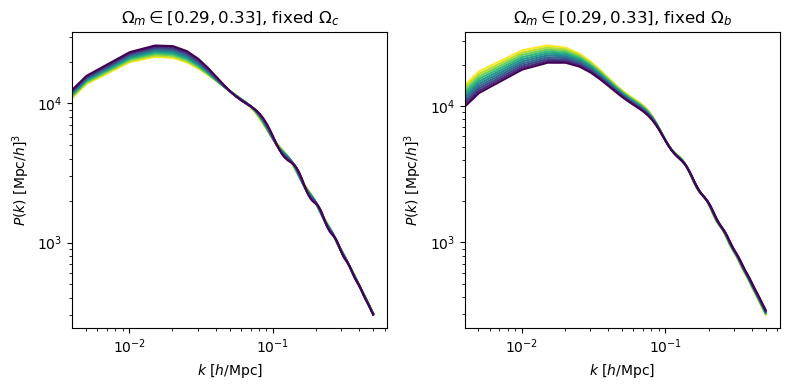

In [106]:
from montecosmo.bricks import Planck18
from montecosmo.plot import plot_pow
import jax_cosmo as jc

n = 10
log = True
ks = jnp.linspace(0, 0.5, 100)
pk_fn = jit(partial(jc.power.linear_matter_power, k=ks, a=1))
Oms = np.linspace(0.29, 0.33, n)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_c$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_b=Om - Planck18().Omega_c)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))

plt.subplot(122)
plt.title("$\\Omega_m \\in [0.29, 0.33]$, fixed $\\Omega_b$")
for i_c, Om in enumerate(Oms):
    cmap = plt.get_cmap('viridis_r', n)
    cosmo = Planck18(Omega_c=Om - Planck18().Omega_b)
    pk = pk_fn(cosmo)
    plot_pow(ks, pk, log=log, color=cmap(i_c))
plt.tight_layout()